# Figures for my MA
1. Map study area 
2. upwelling season mean
    - plot with 4 panels for (a) Ek, (b) SST, (c) SLP and (d) SSH 
3. Upwelling season trend
    - plot with 4 panels for (a) Ek, (b) SST, (c) SLP and (d) SSH
4. UIs 
    - (a) UI<sub>Ek</sub> and (b) UI<sub>SST</sub>
5. UIs long
    - (a) UI<sub>Ek</sub> and (b) UI<sub>SST</sub>
6. Extremes timeline
7. Composties

* Angle $\varphi$ relative to coast? (1.1) 

## Supllementary Material
1. Monthly means of Vars
    - Ek, SST, SLP and SSH
2. Composite plots bottom 10% of events

In [1]:
## save figs
save_var = False

## Import packages and data

In [217]:
## import packages
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
import matplotlib.dates as dates
import cartopy.crs as ccrs
import os
import my_functions
from scipy.stats import linregress
from scipy.stats import pearsonr
from scipy import stats
import cmocean.cm as cmo
%matplotlib inline

In [3]:
## import data
os.chdir('/Users/marie-louisekorte/Documents/Uni Leipzig/Lisbon/Data.nosync/')
MTSS = xr.open_dataset('MTSS_weekly.nc')
SST = xr.open_dataset('CoRTAD_weekly.nc')
SSH = xr.open_dataset('SSH_weekly.nc') # SSH IBI
SLP = xr.open_dataset('SLP_weekly.nc')
Angles = xr.open_dataset('Angles_coast.nc')
# mid-shelf coordinates
mid_shelf_lat = np.genfromtxt('CoRTAD/lat_midshelf_CoRTAD.dat')[:,1]
mid_shelf_lon = np.genfromtxt('CoRTAD/lon_midshelf_CoRTAD.dat')[:,1]

In [4]:
## set dir where I want to save my figures
os.chdir('/Users/marie-louisekorte/Documents/Uni Leipzig/Lisbon/Iberian_Coast_Upwelling/Figures/Report/')

## Data Prep

In [5]:
## selct common period MTSS, SLP and SST
MTSS = MTSS.sel(time = slice('01/01/1982', '31/12/2022'))
SLP = SLP.sel(time = slice('01/01/1982', '31/12/2022'))
SST = SST.sel(time = slice('01/01/1982', '31/12/2022'))

In [6]:
## calculate the UIs (and add mid_shelf mask)
# UI Ek (here near shore directly ... no longer using the 'simplified' 10.5°W version
Ek = MTSS
Ek = my_functions.calc_upwelling_index(MTSS, MTSS.lat, MTSS.lon, MTSS.metss.where(MTSS.lsm), MTSS.mntss.where(MTSS.lsm), near_shore = True, angles = Angles.angle_phi)
Ek = my_functions.add_mid_shelf(Ek, mid_shelf_lat, mid_shelf_lon)
Ek = Ek.drop_vars('UI')
Ek['UI'] = Ek.UI_ns 

# UI SST and SSH
SST = my_functions.add_mid_shelf(SST, mid_shelf_lat, mid_shelf_lon)
SST['UI'] = SST.SST.where(SST.lon == -15.019103) - SST.SST.where(SST.mid_shelf).mean(dim = 'lon')
SST.UI.attrs.update({'Name' : 'SST upwelling index', 'Info' : 'SST at 15° - SST at mid-shelf', 'Sign' : 'positive inidcates upwelling'})

In [8]:
## meridional mean 
# choose min 37.25 and max 43°N -> this is where the UI annual mean of the upwelling season mean is positive (except at Setubal 38.25)
Ek['UI_mean'] = Ek.UI.where((Ek.lat >= 37.25) & (Ek.lon <= 43)).mean(dim = ['lat', 'lon'])
SST = my_functions.calc_meridional_mean(SST, lon = -15.019103, min_lat = 37.25, max_lat = 43.5)

In [9]:
## summer subset (i.e. upwelling season)
Ek_summer = my_functions.subset_summer(Ek)
SLP_summer = my_functions.subset_summer(SLP)
SST_summer = my_functions.subset_summer(SST)
SSH_summer = my_functions.subset_summer(SSH)

In [10]:
## upwelling season annual mean (select relevant variables for faster processing)
Ek_summer_mean = Ek_summer[['ek_trans_u', 'ek_trans_v', 'UI', 'UI_mean','lsm']].resample(time = 'YE', label = 'left').mean(dim = 'time')
SLP_summer_mean = SLP_summer[['msl', 'lsm']].resample(time = 'YE', label = 'left').mean(dim = 'time')
SST_summer_mean = SST_summer[['SST', 'UI', 'UI_mean']].resample(time = 'YE', label = 'left').mean(dim = 'time')
SSH_summer_mean = SSH_summer['zos'].resample(time = 'YE', label = 'left').mean(dim = 'time')

## Functions

### Maps (i.e. Variables / Composites)

In [11]:
## plot map

def plot_map(DS, title = 'Title', cmap = 'coolwarm', vmin = None, vmax = None, cbar_label = 'Label', add_contour = False, save =  save_var, save_fig_as = 'Map', ax = None):
    plt.figure(figsize=(10, 6))
        
    # Set up the map 
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-19, -5.5, 45, 36])
    ax.coastlines()
    gls = ax.gridlines(draw_labels=True, linewidth = 0.5)
    gls.top_labels = False 
    gls.right_labels = False
      
    cp = DS.plot(add_colorbar = False, cmap = cmap, vmin = vmin, vmax = vmax, alpha = 0.8)
    plt.colorbar(cp, ax = ax, label = cbar_label, fraction = 0.046, pad = 0.01);

    if add_contour == True:
        clp = DS.plot.contour(colors = 'black', linewidths = 1, levels = np.arange(1010,1028, 0.25))
        plt.clabel(clp, fontsize = 7)
    
    plt.title(f'{title}')

    if save:
        plt.savefig(f'{save_fig_as}.png', dpi = 300, bbox_inches = 'tight')

    return ax.boxplot(DS)

In [12]:
# plot monthly means
def plot_monthly_means(DS, DS_month, Ek = False, title = 'Title', cbar_label = 'lable', cmap = 'viridis', vmin = -1, vmax = 1, add_contour = False, 
                       save = False, save_fig_as = 'map_monthly_mean'):
    
    xsize = 4 # is actually the number of rows
    ysize = 3 # is the number of collumns
    
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']


    fig, axs = plt.subplots(xsize, ysize, figsize = (12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    i = 0
    for x in np.arange(0, xsize):
        for y in np.arange(0, ysize):
            
            ax = axs[x, y]
            
            ax.set_extent([-19, -5.5, 45, 36])
            ax.coastlines()
            gls = ax.gridlines(draw_labels=True, linewidth = 0.5)
            gls.top_labels = False 
            gls.right_labels = False

            if add_contour:
                clp = DS.where(DS_month == months[i], drop = True).mean(dim = 'time').plot.contour(ax = axs[x, y], colors = 'black', linewidths = 1, levels = np.arange(1010,1028, 0.25))
                plt.clabel(clp, fontsize = 7)

            if Ek == False: 
                cp = DS.where(DS_month == months[i], drop = True).mean(dim = 'time').plot(ax = axs[x, y], transform = ccrs.PlateCarree(), 
                               add_colorbar = False, vmin = vmin, vmax = vmax, extend = 'both', cmap = cmap, alpha = 0.8)
            if Ek == True:
                col = np.hypot(DS.ek_trans_u.where(DS_month == months[i], drop = True).mean(dim = 'time') * 1000, 
                               DS.ek_trans_v.where(DS_month == months[i], drop = True).mean(dim = 'time') * 1000)
                im = ax.quiver(DS.lon, DS.lat, DS.ek_trans_u.where(DS_month == months[i], drop = True).mean(dim = 'time') * 1000, 
                               DS.ek_trans_v.where(DS_month == months[i], drop = True).mean(dim = 'time') * 1000, 
                               col, angles='xy', scale_units='xy', scale = 2 * 1000, clim = [0,1 * 1000]) 
                qk = ax.quiverkey(im, -0.1, 1.07, 1 * 1000, r'1000 $\frac{m^3}{s \ m}$', labelpos='E')
                
            ax.set_title(f'Mean {title} {months[i]}')
            ax.set_xlabel('Longitude [°E]')
            ax.set_ylabel('Latitude [°N]')
    
            i = i + 1
    
    # adjust spacing around subplots (because fig.tight_layout() doesn't work with the method I use to add the colorbar
    plt.subplots_adjust(bottom=0.5, right=1.1, top=1.3)
    
    fig.subplots_adjust(bottom = 0.25)
    cbar_ax = fig.add_axes([0.25, 0.18, 0.7, 0.03])
    if Ek == False:
        fig.colorbar(cp, cax=cbar_ax, orientation = 'horizontal', label = cbar_label)
    if Ek == True: 
        fig.colorbar(im, cax=cbar_ax, orientation = 'horizontal', label = r'Ekamn transport [$\frac{m^3}{s \ km}$]');
        

    if save == True:
        fig.savefig(f'{save_fig_as}.png', dpi = 300, bbox_inches = 'tight')

In [13]:
# calculate trend
def calc_trend_and_significance(data):
    n_time = data.shape[0]
    x = np.arange(n_time)  # Time indices, assumed to be in consistent units (e.g., years)
    slopes = np.empty((data.shape[1], data.shape[2]))
    p_values = np.empty((data.shape[1], data.shape[2]))
    
    for i in range(data.shape[1]):
        for j in range(data.shape[2]):
            y = data[:, i, j]
            regression = linregress(x, y)
            slopes[i, j] = regression.slope
            p_values[i, j] = regression.pvalue
    return slopes, p_values

### UIs

In [456]:
## plot variable, give stats over whole period and last decade

def plot_trend(x_dates, y, col = 'darkcyan', title = 'Title', ylabel = 'Y axis', long = False, ax = None):
    # get values for the trend line analysis
    #fig = plt.figure(figsize = (8, 3))

    # calculate stats whole period
    x = np.arange(len(x_dates))
    regression = linregress(x, y)

    if long == False:
        # define last decades in years and calculate stats
        last_10 = x_dates.dt.isocalendar().year.max().values - 9 # minus nine years because the last year is already fully included 
        x_dates_10 = np.delete(x_dates, (np.where(x_dates.dt.isocalendar().year < last_10)))
        x_10 = np.delete(x, (np.where(x_dates.dt.isocalendar().year < last_10)))
        y_10 = np.delete(y, (np.where(x_dates.dt.isocalendar().year < last_10)))
        regression_10 = linregress(x_10, y_10)
    
        # define second last decades in years and calculate stats
        last_20_min = x_dates.dt.isocalendar().year.max().values - 19  # need to define min and max
        last_20_max = x_dates.dt.isocalendar().year.max().values - 10 
        x_dates_20 = np.delete(x_dates, (np.where((x_dates.dt.isocalendar().year <= last_20_min) | (x_dates.dt.isocalendar().year > last_20_max))))
        x_20 = np.delete(x, (np.where((x_dates.dt.isocalendar().year <= last_20_min) | (x_dates.dt.isocalendar().year > last_20_max))))
        y_20 = np.delete(y, (np.where((x_dates.dt.isocalendar().year <= last_20_min) | (x_dates.dt.isocalendar().year > last_20_max))))
        regression_20 = linregress(x_20, y_20)
    
    # plot 
    # all data
    plt.plot(x_dates, y, marker = '.', markerfacecolor = col, alpha = 0.5, color = col)
    # trend whole period
    plt.plot(x_dates, x*regression.slope + regression.intercept, "k-", alpha = 0.8, lw = 1, 
             label = f'{x_dates.dt.isocalendar().year.min().values+1}-{x_dates.dt.isocalendar().year.max().values+1} \ntrend: {regression.slope:.4f} \np-value: {regression.pvalue:.4f}') 
    
    if long == False:
        # 10 years before that ('second last' decade)
        plt.plot(x_dates_20, x_20*regression_20.slope + regression_20.intercept, "k--", lw = 1, 
                 label = f'{last_20_min+1}-{last_20_max+1} \ntrend: {regression_20.slope:.4f} \np-value: {regression_20.pvalue:.4f} ') 
        # last 10 years
        plt.plot(x_dates_10, x_10*regression_10.slope + regression_10.intercept, "k:", 
                 label = f'{last_10+1}-{x_dates.dt.isocalendar().year.max().values+1} \ntrend: {regression_10.slope:.4f} \np-value: {regression_10.pvalue:.4f}') 
    
    plt.legend(bbox_to_anchor=(1, 1.05), loc = 'upper left', labelspacing = 2, edgecolor = 'none', facecolor = 'none', fontsize = 'small')
    plt.title(title)
    #plt.xlabel('Year')
    plt.ylabel(ylabel)
    plt.xlim(dates.date2num(['1980']), dates.date2num(['2025']))
    
    if long:
        plt.xlim(dates.date2num(['1938']), dates.date2num(['2025']))
        
    plt.grid(lw = 0.5)
   
    fig.tight_layout()

### Extremes

In [333]:
def plot_extreme_occurence(Ek, SST, sub_start = 0, sub_stop = 0.1, title = 'Top 10% of upwelling weeks', variables = False, save = save_var, save_fig_as = 'Extremes'):

    # order and do subselection (based on percentage of values) [subset desired values]
    # it odrders my array and starts with the highest values -› index 0 is highest
    Ek_sub = Ek.time.sortby(Ek.UI_mean, ascending = False).values[round(Ek.time.shape[0] * sub_start) : round(Ek.time.shape[0] * sub_stop)]
    SST_sub = SST.time.sortby(SST.UI_mean, ascending = False).values[round(SST.time.shape[0] * sub_start) : round(SST.time.shape[0] * sub_stop)]
    
    fig = plt.figure(figsize = (15,1.2))
    plt.scatter(Ek_summer.time.sel(time = Ek_sub), np.zeros(len(Ek_sub))+1, marker = "|", s = 200, color = 'darkcyan', alpha = 0.4, label = r'$\rm UI_{Ek}$')
    plt.scatter(SST_summer.time.sel(time = SST_sub), np.zeros(len(SST_sub))+0.5, marker = "|",  s = 200, color = 'rebeccapurple', alpha = 0.4, label = r'$\rm UI_{SST}$')
    #plt.xticks(dates.date2num([str(np.arange(1980, 2024, 1))]))
    #plt.xticks(Ek_summer.time.dt.year.values)
    plt.yticks([])
    plt.ylim(0.3,1.2)
    #plt.xticks(Ek_summer.time.dt.year, minor=True)
    #plt.xaxis.grid(True, which='minor')
    #plt.grid(which = 'minor', axis = 'x', xdata = Ek_summer.time.dt.year)
    plt.grid()
    plt.legend(bbox_to_anchor=(1, 0.98), labelspacing = 2.5, loc = 'upper left', edgecolor = 'none', facecolor = 'none'),
    plt.title(title)

    if save:
        fig.savefig(f'{save_fig_as}.png', dpi = 300, bbox_inches = 'tight')
        
    if variables:
        return Ek_sub, SST_sub
    
        

## Map of study area

## Upwelling season mean (usm)

In [16]:
Ek_usm = Ek_summer_mean[['ek_trans_u', 'ek_trans_v']].mean(dim = 'time') * 1000 # make it m3/s km
Ek_usm['magnitude'] = np.hypot(Ek_usm.ek_trans_u, Ek_usm.ek_trans_v)
SST_usm = SST_summer_mean.SST.mean(dim = 'time')
SLP_usm = SLP_summer_mean.msl.where(SLP_summer_mean.lsm).mean(dim = 'time') * 0.01 # make it hPa
SSH_usm = SSH_summer_mean.mean(dim = 'time') * 100 # make it cm

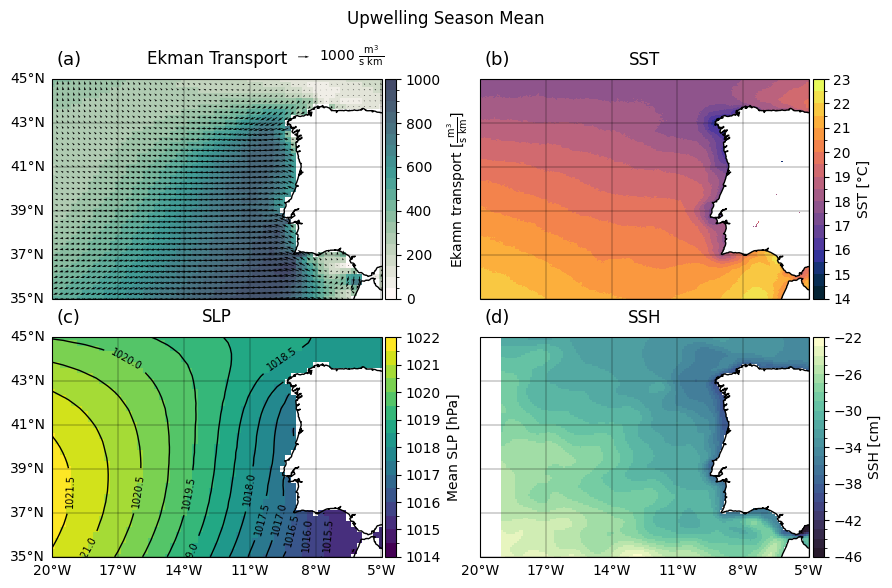

In [389]:
fig, ax = plt.subplots(2, 2, figsize = (9,6), subplot_kw={'projection': ccrs.PlateCarree()})
ax = ax.flatten()

# set up cartopy for all plots
for i in np.arange(4):
    ax[i].set_extent([-20.01, -4.99, 45.01, 34.99])
    ax[i].coastlines()
    gls = ax[i].gridlines(draw_labels=True, linewidth = 0.25, color = 'black')
    gls.top_labels = False 
    gls.right_labels = False
    gls.xlocator = mticker.FixedLocator(np.arange(-20, -4, 3))
    gls.ylocator = mticker.FixedLocator(np.arange(35, 46, 2))
    if i in (1, 3):
        gls.left_labels = False
    if i in (0, 1):
        gls.bottom_labels = False

# col = np.hypot(Ek_usm.ek_trans_u, Ek_usm.ek_trans_v)
# im = ax[0].quiver(Ek_usm.lon, Ek_usm.lat, Ek_usm.ek_trans_u, Ek_usm.ek_trans_v, col, angles='xy', scale_units='xy', scale = 2*1000, clim = [0,1*1000]) 

mag = np.hypot(Ek_usm.ek_trans_u, Ek_usm.ek_trans_v)
cp = Ek_usm.magnitude.plot(ax = ax[0], add_colorbar = False, cmap = cmo.tempo, vmin = 0, vmax = 1000, alpha = 0.8, levels = np.arange(0, 1050, 50))
im = ax[0].quiver(Ek_usm.lon, Ek_usm.lat, Ek_usm.ek_trans_u, Ek_usm.ek_trans_v, angles='xy', scale_units='xy', scale = 2*1000, clim = [0,1*1000]) 
plt.colorbar(cp, ax = ax[0], label = r'Ekamn transport [$\frac{\rm m^3}{\rm s \ km}$]', fraction = 0.0319, pad = 0.01, ticks = np.arange(0, 1200, 200));
ax[0].set_title('Ekman Transport')
ax[0].text(-19.8, 45.65, '(a)', fontsize = 13)
ax[0].quiverkey(im, 0.78, 1.1, 1*1000, r'1000 $\frac{\rm m^3}{\rm s \ km}$', labelpos='E')

cp = SST_usm.plot(ax = ax[1], add_colorbar = False, cmap = cmo.thermal, vmin = 14, vmax = 23, levels = np.arange(14, 23.5, 0.5))
plt.colorbar(cp, ax = ax[1], label = 'SST [°C]', fraction = 0.0319, pad = 0.01) 
ax[1].set_title('SST', pad = 10)
ax[1].text(-19.8, 45.65, '(b)', fontsize = 13)

cp = SLP_usm.plot(ax = ax[2], add_colorbar = False, cmap = 'viridis', vmin = 1014, vmax = 1022, levels = np.arange(1014, 1022.5, 0.5))
clp = SLP_usm.plot.contour(ax = ax[2], colors = 'black', linewidths = 1, levels = np.arange(1014, 1022.5, 0.5))
plt.colorbar(cp, ax = ax[2], label = 'Mean SLP [hPa]', fraction = 0.0319, pad = 0.01) 
plt.clabel(clp, fontsize = 7)
ax[2].set_title('SLP')
ax[2].text(-19.8, 45.65, '(c)', fontsize = 13)

cp = SSH_usm.plot(ax = ax[3], add_colorbar = False, cmap = cmo.deep_r, vmin = -46, vmax = -22, levels = np.arange(-46, -21, 1))
cbar = plt.colorbar(cp, ax = ax[3], label = 'SSH [cm]', fraction = 0.0319, pad = 0.01, ticks = np.arange(-46, -20, 4))
#cbar.ax.locator_params(nbins = 4)
ax[3].set_title('SSH', pad = 10)
ax[3].text(-19.8, 45.65, '(d)', fontsize = 13)

fig.suptitle('Upwelling Season Mean')
fig.tight_layout(pad=1, w_pad=0, h_pad=-0.8)
fig.savefig('Upwelling_Season_Mean.png', dpi = 300, bbox_inches = 'tight')

In [18]:
# min and max values overall 
print('Ek (combined) min:', mag.min().values, 'max: ', mag.max().values)
print('SST min: ', SST_usm.min().values, 'max: ', SST_usm.max().values)
print('SLP min: ', SLP_usm.min().values, 'max: ', SLP_usm.max().values)
print('SSH min: ', SSH_usm.min().values, 'max: ', SSH_usm.max().values)

Ek (combined) min: 31.602329580437676 max:  966.3344945487348
SST min:  14.744092140921408 max:  22.40334688346884
SLP min:  1014.9831 max:  1021.72076
SSH min:  -45.65161683719141 max:  -22.636673215304643


## Upwelling season trend

In [19]:
Ek_u_us_trend, Ek_u_us_pvalues = calc_trend_and_significance(Ek_summer_mean.ek_trans_u * 1000) # make it m3/s km
Ek_v_us_trend, Ek_v_us_pvalues = calc_trend_and_significance(Ek_summer_mean.ek_trans_v * 1000) # make it m3/s km
Ek_summer_mean['magnitude'] = np.hypot(Ek_summer_mean.ek_trans_u * 1000, Ek_summer_mean.ek_trans_v * 1000) # make it m3/s km   
Ek_mag_us_trend, Ek_mag_us_pvalues = calc_trend_and_significance(Ek_summer_mean.magnitude) # trend of the Ekman transport magnitude 
SST_us_trend, SST_us_pvalues = calc_trend_and_significance(SST_summer_mean.SST)
SLP_us_trend, SLP_us_pvalues = calc_trend_and_significance(SLP_summer_mean.msl.where(SLP_summer_mean.lsm))
SSH_us_trend, SSH_us_pvalues = calc_trend_and_significance(SSH_summer_mean * 1000) # make it mm

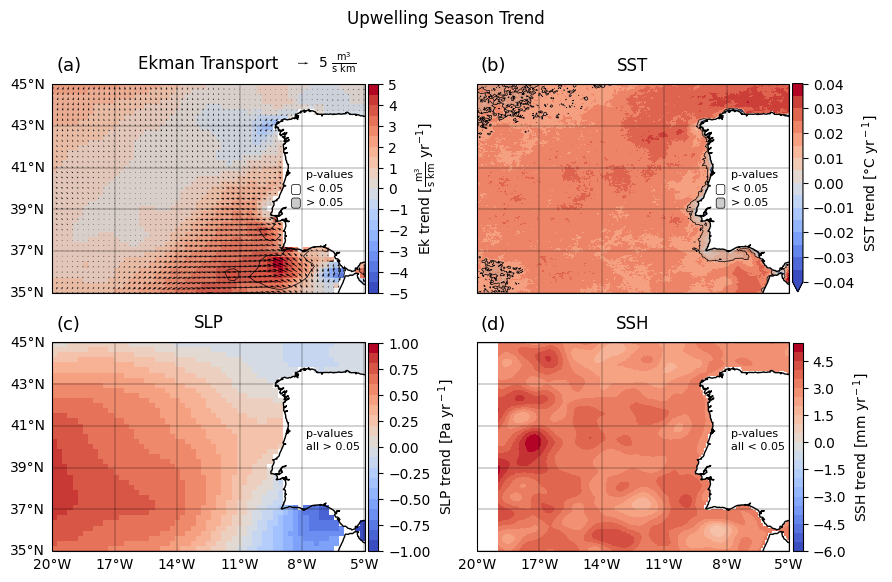

In [384]:
sig_level = 0.05 # set significance level for plotting p-values
cmap = plt.get_cmap('coolwarm')

fig, ax = plt.subplots(2, 2, figsize = (9,6), subplot_kw={'projection': ccrs.PlateCarree()})
ax = ax.flatten()

# set up cartopy for all plots
for i in np.arange(4):
    ax[i].set_extent([-20.01, -4.99, 45.01, 34.99])
    ax[i].coastlines()
    gls = ax[i].gridlines(draw_labels=True, linewidth = 0.25, color = 'black')
    gls.top_labels = False 
    gls.right_labels = False
    gls.xlocator = mticker.FixedLocator(np.arange(-20, -4, 3))
    gls.ylocator = mticker.FixedLocator(np.arange(35, 46, 2))
    if i in (1, 3):
        gls.left_labels = False
    if i in (0, 1):
        gls.bottom_labels = False


## Ek
mag = np.hypot(Ek_u_us_trend, Ek_v_us_trend)
norm = mcolors.BoundaryNorm(np.arange(-5, 5.5, 0.5), ncolors = cmap.N, clip = True)
cp = ax[0].imshow(Ek_mag_us_trend, origin = 'lower', cmap = cmap, extent=[-20, -5, 35, 45], norm = norm) 
cb = plt.colorbar(cp, ax = ax[0], label = r'Ek trend [$\frac{\rm m^3}{\rm s \ km}$ yr$^{-1}$]', fraction = 0.0319, pad = 0.01, ticks = np.arange(-5, 6, 1))
cb.ax.minorticks_off()
im = ax[0].quiver(Ek_usm.lon, Ek_usm.lat, Ek_u_us_trend, Ek_v_us_trend, angles='xy', scale_units='xy', scale = 10) #, clim = [0,1*1000]) 
## alternative code for plotting coloured arrows (instead of black arrows ontop of imshow plot)
#im = ax[0].quiver(Ek_usm.lon, Ek_usm.lat, Ek_u_us_trend, Ek_v_us_trend, mag, cmap = 'coolwarm', angles='xy', scale_units='xy', scale = 10, clim = [-5, 5]) 
#plt.colorbar(im, ax = ax[0], label = r'Ekamn transport [$\frac{\rm m^3}{\rm s \ km}$]', fraction = 0.0319, pad = 0.01)
ax[0].quiverkey(im, 0.82, 1.1, 5, r'5 $\frac{\rm m^3}{\rm s \ km}$', labelpos = 'E')
ax[0].set_title('Ekman Transport')
ax[0].text(-19.8, 45.65, '(a)', fontsize = 13)

ax[0].contour(Ek_usm.lon, Ek_usm.lat, Ek_mag_us_pvalues, [0.05], cmap = 'magma', linewidths = 0.5)
ax[0].contourf(Ek_usm.lon, Ek_usm.lat, Ek_mag_us_pvalues, [0.05, 1], cmap = 'binary', alpha = 0.1)

# legend
ax[0].text(-7.8, 40.5, s = 'p-values', fontsize = 8)
ax[0].text(-8.4, 39.85, s='  ', size = 5, bbox=dict(boxstyle="round", ec=(0, 0, 0), fc=(1, 1, 1), linewidth = 0.5))
ax[0].text(-7.8, 39.85, '< 0.05', fontsize = 8)
ax[0].text(-8.4, 39.2, s='  ', size = 5, bbox=dict(boxstyle="round", ec=(0, 0, 0), fc=(0.8, 0.8, 0.8), linewidth = 0.5))
ax[0].text(-7.8, 39.2, '> 0.05', fontsize = 8)

## SST
norm = mcolors.BoundaryNorm(np.arange(-0.04, 0.045, 0.005), ncolors = cmap.N, clip = True)
cp = ax[1].imshow(SST_us_trend, origin = 'lower', cmap = cmap, extent=[-20, -5, 35, 45], norm = norm)
cb = plt.colorbar(cp, ax = ax[1], label = r'SST trend [°C yr$^{\rm -1}$]', fraction = 0.0319, pad = 0.01, extend = 'min') 
cb.ax.minorticks_off()
ax[1].set_title('SST', pad = 10)

#sig_indices = np.where(SST_us_pvalues < sig_level)
#plt.scatter(SST_usm.lon[sig_indices[1]], SST_usm.lat[sig_indices[0]], color = 'k')
ax[1].contour(SST_usm.lon, SST_usm.lat, SST_us_pvalues, [0.05], cmap = 'magma', linewidths = 0.5)
ax[1].contourf(SST_usm.lon, SST_usm.lat, SST_us_pvalues, [0.05, 1], cmap = 'binary', alpha = 0.2)

# legend
ax[1].text(-19.8, 45.65, '(b)', fontsize = 13)
ax[1].text(-7.8, 40.5, s = 'p-values', fontsize = 8)
ax[1].text(-8.4, 39.85, s='  ', size = 5, bbox=dict(boxstyle="round", ec=(0, 0, 0), fc=(1, 1, 1), linewidth = 0.5))
ax[1].text(-7.8, 39.85, '< 0.05', fontsize = 8)
ax[1].text(-8.4, 39.2, s='  ', size = 5, bbox=dict(boxstyle="round", ec=(0, 0, 0), fc=(0.8, 0.8, 0.8), linewidth = 0.5))
ax[1].text(-7.8, 39.2, '> 0.05', fontsize = 8)

## SLP 
norm = mcolors.BoundaryNorm(np.arange(-1, 1.1, 0.1), ncolors = cmap.N, clip = True)
cp = ax[2].imshow(SLP_us_trend, origin = 'lower', cmap = cmap, extent=[-20, -5, 35, 45], norm = norm) 
cb = plt.colorbar(cp, ax = ax[2], label = r'SLP trend [Pa yr$^{\rm -1}$]', fraction = 0.0319, pad = 0.01, ticks = np.arange(-1, 1.25, 0.25))
cb.ax.minorticks_off()
ax[2].set_title('SLP')
ax[2].text(-19.8, 45.65, '(c)', fontsize = 13)
ax[2].text(-7.8, 40.5, s = 'p-values', fontsize = 8)
ax[2].text(-7.8, 39.85, 'all > 0.05', fontsize = 8)

#ax[2].contour(SLP_usm.lon, SLP_usm.lat, SLP_us_pvalues, [0.05], cmap = 'magma', linewidths = 0.5)
#ax[2].contourf(SLP_usm.lon, SLP_usm.lat, SLP_us_pvalues, [0.05, 1], cmap = 'binary', alpha = 0.1)

norm = mcolors.BoundaryNorm(np.arange(-6, 6, 0.5), ncolors = cmap.N, clip = True)
cp = ax[3].imshow(SSH_us_trend, origin = 'lower', cmap = cmap, extent=[-19, -5, 35, 45], norm = norm) 
cb = plt.colorbar(cp, ax = ax[3], label = r'SSH trend [mm yr$^{\rm -1}$]', fraction = 0.0319, pad = 0.01) #, ticks = np.arange(-1, 1.2, 0.2))
cb.ax.minorticks_off()
ax[3].set_title('SSH', pad = 10)
ax[3].text(-19.8, 45.65, '(d)', fontsize = 13)
ax[3].text(-7.8, 40.5, s = 'p-values', fontsize = 8)
ax[3].text(-7.8, 39.85, 'all < 0.05', fontsize = 8)

#ax[3].contour(SSH_usm.lon, SSH_usm.lat, SSH_us_pvalues, [0.05], cmap = 'magma', linewidths = 0.5)
#ax[3].contourf(SSH_usm.lon, SSH_usm.lat, SSH_us_pvalues, [0.05, 1], cmap = 'binary', alpha = 0.1)

fig.suptitle('Upwelling Season Trend')
fig.tight_layout(pad=1, w_pad=0, h_pad=-0.8)
fig.savefig('Upwelling_Season_Trend.png', dpi = 300, bbox_inches = 'tight')

In [21]:
print('Ek mag trend min: ', np.nanmin(Ek_mag_us_trend), 'max: ', np.nanmax(Ek_mag_us_trend))
print('SST trend min: ', np.nanmin(SST_us_trend), 'max: ', np.nanmax(SST_us_trend))
print('SLP trend min: ', np.nanmin(SLP_us_trend), 'max: ', np.nanmax(SLP_us_trend))
print('SSH trend min: ', np.nanmin(SSH_us_trend), 'max: ', np.nanmax(SSH_us_trend))

Ek mag trend min:  -3.512756948946216 max:  4.786907528345153
SST trend min:  -0.24151258226867986 max:  0.03988124274099877
SLP trend min:  -1.065193543118467 max:  0.8545228114111498
SSH trend min:  1.1692196974146927 max:  5.407909397529664


In [445]:
# overall SST trend in study region
x = np.arange(len(SST_summer_mean.time))
linregress(x, SST_summer_mean.SST.mean(dim = ['lon', 'lat']))

LinregressResult(slope=0.021646481262896297, intercept=19.045390959105223, rvalue=0.5333485704446567, pvalue=0.0003299158530244871, stderr=0.005497441512119735, intercept_stderr=0.12774899653913432)

In [447]:
# overall SSH trend in study region
x = np.arange(len(SSH_summer_mean.time))
linregress(x, SSH_summer_mean.mean(dim = ['lon', 'lat']))

LinregressResult(slope=0.0031858328704947475, intercept=-0.34561506028217154, rvalue=0.910760597784234, pvalue=7.0567303370204705e-12, stderr=0.0002779830643389891, intercept_stderr=0.0045337665753512665)

## UIs

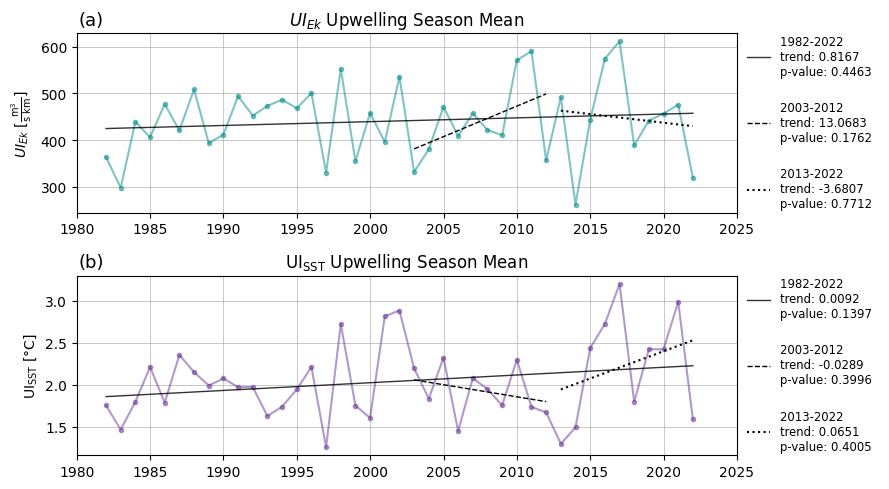

In [457]:
fig = plt.figure(figsize = (9, 5))
ax1 = plt.subplot(2,1,1)
plot_trend(Ek_summer_mean.time, Ek_summer_mean.UI_mean * 1000, title = r'$UI_{Ek}$ Upwelling Season Mean', ylabel = r'$UI_{Ek} \ [\frac{\rm m^3}{\rm s \ km}]$')
ax1.text(3700, 645, '(a)', fontsize = 13) 
ax2 = plt.subplot(2,1,2)
plot_trend(SST_summer_mean.time, SST_summer_mean.UI_mean, col = 'rebeccapurple', title = r'$\rm UI_{SST}$ Upwelling Season Mean', ylabel = r'$\rm UI_{SST}$ [°C]')
ax2.text(3700, 3.4, '(b)', fontsize = 13);
fig.savefig('UIs.png', dpi = 300, bbox_inches = 'tight')

## UIs long

In [23]:
# UI Ek and ERA5 SST over the whole period
MTSS_all = xr.open_dataset('/Users/marie-louisekorte/Documents/Uni Leipzig/Lisbon/Data.nosync/MTSS_all_weekly.nc')
ERA5_SST = xr.open_dataset('/Users/marie-louisekorte/Documents/Uni Leipzig/Lisbon/Data.nosync/ERA5_SST_weekly.nc')

In [24]:
## select same 'end point' -> optional, I decided to go with longest possible period
#MTSS_all = MTSS_all.sel(time = slice(None, '31/12/2022'))
#ERA5_SST = ERA5_SST.sel(time = slice(None, '31/12/2022'))

In [25]:
Ek_all = MTSS_all
Angles 
Ek_all = my_functions.calc_upwelling_index(MTSS_all, MTSS_all.lat, MTSS_all.lon, MTSS_all.metss.where(MTSS_all.lsm), MTSS_all.mntss.where(MTSS_all.lsm), near_shore = True, angles = Angles.angle_phi)
Ek_all = Ek_all.drop_vars('UI')
Ek_all['UI'] = Ek_all.UI_ns 

# UI SST and SSH
ERA5_SST = my_functions.add_mid_shelf(ERA5_SST, mid_shelf_lat, mid_shelf_lon)
ERA5_SST['UI'] = ERA5_SST.SST.where(ERA5_SST.lon == -15) - ERA5_SST.SST.where(ERA5_SST.mid_shelf).mean(dim = 'lon')
ERA5_SST.UI.attrs.update({'Name' : 'SST upwelling index', 'Info' : 'SST at 15° - SST at mid-shelf', 'Sign' : 'positive inidcates upwelling'})

In [26]:
# choose min 37.25 and max 43°N -> this is where the UI annual mean of the upwelling season mean is positive (except at Setubal 38.25)
Ek_all['UI_mean'] = Ek_all.UI.where((Ek_all.lat >= 37.25)&(Ek_all.lon <= 43)).mean(dim = ['lat', 'lon'])
ERA5_SST = my_functions.calc_meridional_mean(ERA5_SST, lon = -15, min_lat = 37.25, max_lat = 43.5)

In [27]:
Ek_all_summer = my_functions.subset_summer(Ek_all)
ERA5_SST_summer = my_functions.subset_summer(ERA5_SST)

In [28]:
Ek_all_summer_mean = Ek_all_summer['UI_mean'].resample(time = 'YE', label = 'left').mean(dim = 'time') # label is assigned to start of year
ERA5_SST_summer_mean = ERA5_SST_summer['UI_mean'].resample(time = 'YE', label = 'left').mean(dim = 'time') # label is assigned to start of year

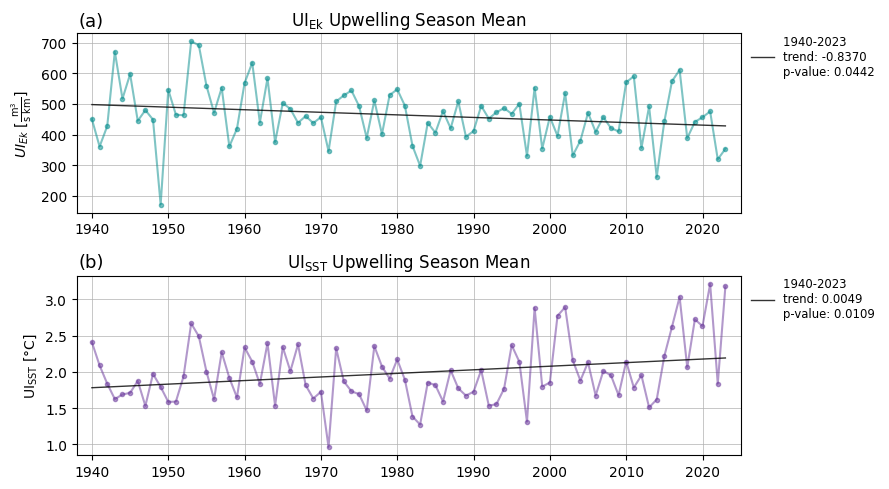

In [458]:
fig = plt.figure(figsize = (9, 5))
ax1 = plt.subplot(2,1,1)
plot_trend(Ek_all_summer_mean.time, Ek_all_summer_mean * 1000, title = r'$\rm UI_{Ek}$ Upwelling Season Mean', ylabel = r'$UI_{Ek} \ [\frac{\rm m^3}{\rm s \ km}]$', long = True)
ax1.text(-11600, 755, '(a)', fontsize = 13) 
ax2 = plt.subplot(2,1,2)
plot_trend(ERA5_SST_summer_mean.time, ERA5_SST_summer_mean, col = 'rebeccapurple', title = r'$\rm UI_{SST}$ Upwelling Season Mean', ylabel = r'$\rm UI_{SST}$ [°C]', long = True)
ax2.text(-11600, 3.45, '(b)', fontsize = 13);
fig.savefig('UIs_long.png', dpi = 300, bbox_inches = 'tight')

## Correlation

Text(0.2, 0, 'correlation: 0.3358733235723638 \np-value: 0.0017872911193582927')

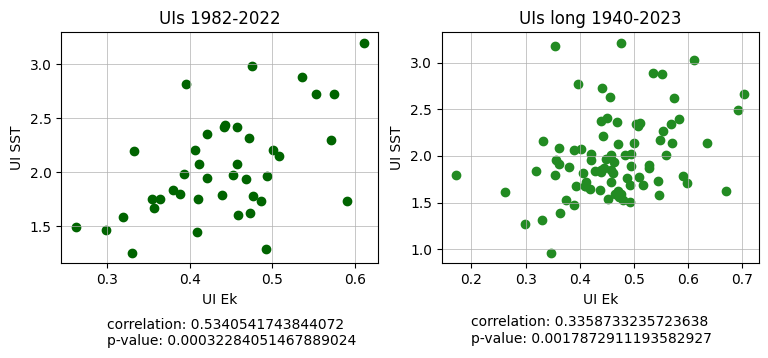

In [75]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (9, 3))
ax1.scatter(Ek_summer_mean.UI_mean, SST_summer_mean.UI_mean, color = 'darkgreen')
ax1.set_title('UIs 1982-2022')
ax1.set_xlabel('UI Ek')
ax1.set_ylabel('UI SST')
ax1.grid(lw = 0.5)

result = pearsonr(Ek_summer_mean.UI_mean, SST_summer_mean.UI_mean)
ax1.text(0.3, 0.4, f'correlation: {result[0]} \np-value: {result[1]}')

ax2.scatter(Ek_all_summer_mean, ERA5_SST_summer_mean, color = 'forestgreen')
ax2.set_title('UIs long 1940-2023')
ax2.set_xlabel('UI Ek')
ax2.set_ylabel('UI SST')
ax2.grid(lw = 0.5)

result = pearsonr(Ek_all_summer_mean, ERA5_SST_summer_mean)
ax2.text(0.2, 0, f'correlation: {result[0]} \np-value: {result[1]}')

## Extremes

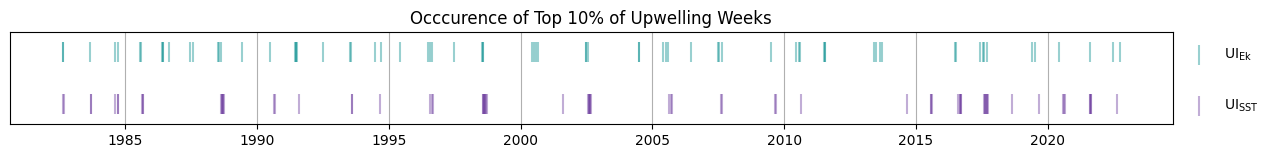

In [336]:
Ek_sub_summer, SST_sub_summer = plot_extreme_occurence(Ek_summer, SST_summer, title = 'Occcurence of Top 10% of Upwelling Weeks', 
                                variables = True, save = True, save_fig_as = 'Extreme_top_10') # by default does to 10% 

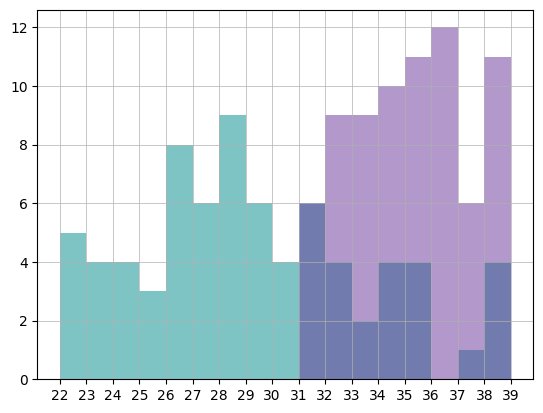

In [324]:
plt.hist(Ek_summer.week_of_year.sel(time = Ek_sub_summer), color = 'darkcyan', bins = np.arange(22, 40, 1), alpha = 0.5)
plt.hist(SST_summer.week_of_year.sel(time = SST_sub_summer), color = 'rebeccapurple', bins = np.arange(22, 40, 1), alpha = 0.5)
plt.grid(lw = 0.5)
plt.xticks(np.arange(22, 40, 1));

In [234]:
## not really sure what this does
stats.kstest(Ek_summer.sel(time = Ek_sub_summer).time.dt.year, stats.randint.cdf(np.unique(Ek_summer.time.dt.year.values), 1982, 2022))

KstestResult(statistic=1.0, pvalue=7.566056842000338e-32, statistic_location=1.0, statistic_sign=-1)

In [354]:
SST_year = np.empty(41)
SST_year.fill(np.nan)
Ek_year = np.empty(41)
Ek_year.fill(np.nan)

SST_years = SST_summer.sel(time = SST_sub_summer).time.dt.year
Ek_years = Ek_summer.sel(time = Ek_sub_summer).time.dt.year

years = np.arange(1982, 2023)
for i in np.arange(41):
    SST_year[i] = (SST_years == years[i]).sum()
    Ek_year[i] = (Ek_years == years[i]).sum()
    

(1980.0, 2024.0)

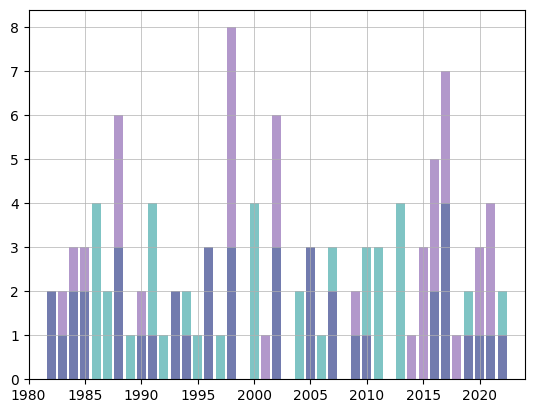

In [270]:
plt.bar(years, Ek_year, color = 'darkcyan', alpha = 0.5)
plt.bar(years, SST_year, color = 'rebeccapurple', alpha = 0.5)
plt.grid(lw = 0.5)
plt.xlim(1980, 2024)

In [355]:
x = np.empty(41)
x.fill(74/41) 

In [356]:
stats.chisquare(SST_year, x)

Power_divergenceResult(statistic=98.86486486486486, pvalue=6.847653556934075e-07)

In [357]:
stats.chisquare(Ek_year, x)

Power_divergenceResult(statistic=37.91891891891892, pvalue=0.5643015171224002)

In [360]:
pearsonr(SST_year, Ek_year)

PearsonRResult(statistic=0.31164058790507837, pvalue=0.047315421049051655)

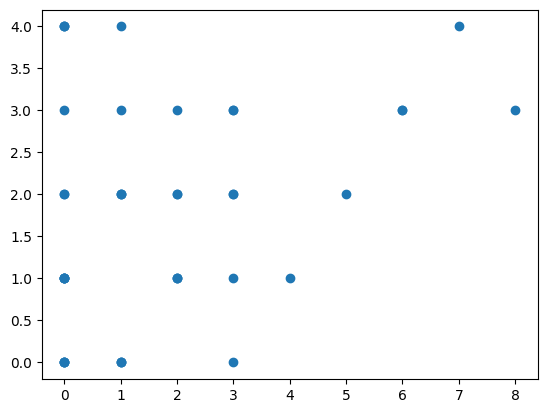

In [361]:
plt.scatter(SST_year, Ek_year)

In [202]:
SST_month = np.zeros(4)
Ek_month = np.zeros(4)

months = ['Jun', 'Jul', 'Aug', 'Sep']
for i in np.arange(4):
    SST_month[i] = (SST_summer.month.sel(time = SST_sub_summer).values == months[i]).sum()
    Ek_month[i] = (Ek_summer.month.sel(time = Ek_sub_summer).values == months[i]).sum()
    

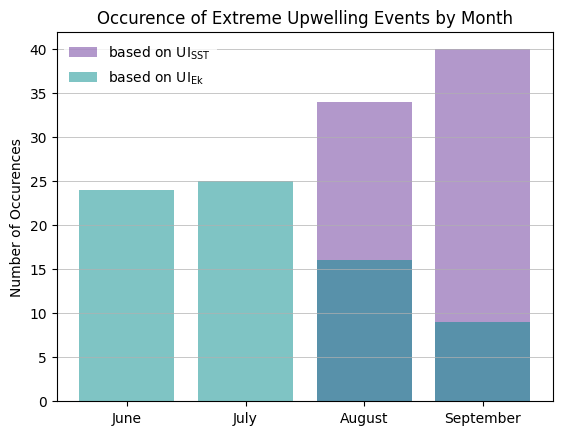

In [344]:
plt.bar(['June', 'July', 'August', 'September'], SST_month, color = 'rebeccapurple', alpha = 0.5, label = r'based on $\rm UI_{SST}$')
plt.bar(['June', 'July', 'August', 'September'], Ek_month, color = 'darkcyan', alpha = 0.5, label = r'based on $\rm UI_{Ek}$')
plt.grid(lw = 0.5, axis = 'y')
plt.legend( edgecolor = 'none', facecolor = 'white') # bbox_to_anchor = (1,1), loc = 'upper left'
plt.title('Occurence of Extreme Upwelling Events by Month')
plt.ylabel('Number of Occurences')
plt.savefig('Extreme_by_month.png', dpi = 300, bbox_inches = 'tight')

In [320]:
Ek_month.sum()/4

18.5

In [251]:
stats.chisquare(Ek_month, [18.5, 18.5, 18.5, 18.5])

Power_divergenceResult(statistic=9.135135135135135, pvalue=0.02754711392714924)

In [252]:
stats.chisquare(SST_month, [18.5, 18.5, 18.5, 18.5])

Power_divergenceResult(statistic=74.97297297297297, pvalue=3.67197065112711e-16)

## Composties (top 10%)

In [439]:
Ek_comp = Ek_summer.sel(time = Ek_sub_summer)[['ek_trans_u', 'ek_trans_v']].mean(dim = 'time') * 1000 # make it m3/s km
Ek_comp['magnitude'] = np.hypot(Ek_comp.ek_trans_u, Ek_comp.ek_trans_v) # probably trustworthy... compare to mag below
SST_comp = SST_summer.sel(time = Ek_sub_summer).SST.mean(dim = 'time')
SLP_comp = SLP_summer.sel(time = Ek_sub_summer).msl.where(SLP_summer.lsm).mean(dim = 'time') * 0.01 # make it hPa
SSH_comp = SSH_summer.sel(time = Ek_sub_summer[np.where((Ek_sub_summer > np.datetime64('1993-01-01')) & (Ek_sub_summer < np.datetime64('2021-12-31')))]).zos.mean(dim = 'time') * 100 # make it cm

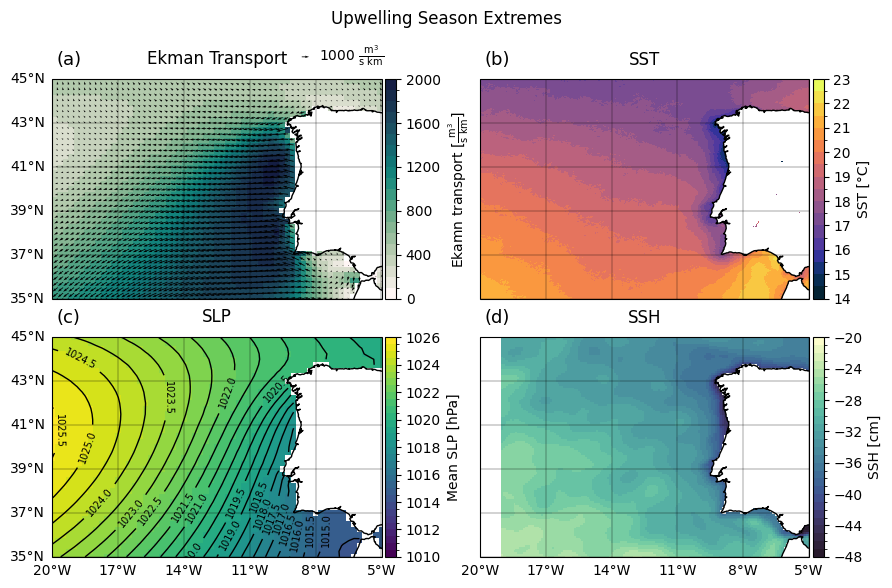

In [440]:
fig, ax = plt.subplots(2, 2, figsize = (9,6), subplot_kw={'projection': ccrs.PlateCarree()})
ax = ax.flatten()

# set up cartopy for all plots
for i in np.arange(4):
    ax[i].set_extent([-20.01, -4.99, 45.01, 34.99])
    ax[i].coastlines()
    gls = ax[i].gridlines(draw_labels=True, linewidth = 0.25, color = 'black')
    gls.top_labels = False 
    gls.right_labels = False
    gls.xlocator = mticker.FixedLocator(np.arange(-20, -4, 3))
    gls.ylocator = mticker.FixedLocator(np.arange(35, 46, 2))
    if i in (1, 3):
        gls.left_labels = False
    if i in (0, 1):
        gls.bottom_labels = False


#cp = Ek_comp.magnitude.plot(ax = ax[0], add_colorbar = False, cmap = cmo.tempo, vmin = 0, vmax = 2000, alpha = 0.8, levels = np.arange(0, 2100, 100))
mag = np.hypot(Ek_comp.ek_trans_u, Ek_comp.ek_trans_v)
cmap = cmo.tempo
norm = mcolors.BoundaryNorm(np.arange(0, 2100, 100), ncolors = cmap.N, clip = True)
cp = ax[0].imshow(mag, origin = 'lower', extent=[-20, -5, 35, 45], norm = norm, cmap = cmap)
im = ax[0].quiver(Ek_comp.lon, Ek_comp.lat, Ek_comp.ek_trans_u, Ek_comp.ek_trans_v, angles='xy', scale_units='xy', scale = 3*1000) #, clim = [0,2*1000]) 
plt.colorbar(cp, ax = ax[0], label = r'Ekamn transport [$\frac{\rm m^3}{\rm s \ km}$]', fraction = 0.0319, pad = 0.01, ticks = np.arange(0, 2400, 400));
ax[0].set_title('Ekman Transport')
ax[0].text(-19.8, 45.65, '(a)', fontsize = 13)
ax[0].quiverkey(im, 0.78, 1.1, 1*1000, r'1000 $\frac{\rm m^3}{\rm s \ km}$', labelpos='E')

cp = SST_comp.plot(ax = ax[1], add_colorbar = False, cmap = cmo.thermal, vmin = 14, vmax = 23, levels = np.arange(14, 23.5, 0.5))
plt.colorbar(cp, ax = ax[1], label = 'SST [°C]', fraction = 0.0319, pad = 0.01) 
ax[1].set_title('SST', pad = 10)
ax[1].text(-19.8, 45.65, '(b)', fontsize = 13)

cp = SLP_comp.plot(ax = ax[2], add_colorbar = False, cmap = 'viridis', vmin = 1010, vmax = 1026, levels = np.arange(1010, 1026.5, 0.5))
clp = SLP_comp.plot.contour(ax = ax[2], colors = 'black', linewidths = 1, levels = np.arange(1010, 1026.5, 0.5))
plt.colorbar(cp, ax = ax[2], label = 'Mean SLP [hPa]', fraction = 0.0319, pad = 0.01) 
plt.clabel(clp, fontsize = 7)
ax[2].set_title('SLP')
ax[2].text(-19.8, 45.65, '(c)', fontsize = 13)

cp = SSH_comp.plot(ax = ax[3], add_colorbar = False, cmap = cmo.deep_r, vmin = -48, vmax = -22, levels = np.arange(-48, -19, 1))
cbar = plt.colorbar(cp, ax = ax[3], label = 'SSH [cm]', fraction = 0.0319, pad = 0.01, ticks = np.arange(-48, -16, 4))
#cbar.ax.locator_params(nbins = 4)
ax[3].set_title('SSH', pad = 10)
ax[3].text(-19.8, 45.65, '(d)', fontsize = 13)

fig.suptitle('Upwelling Season Extremes')
fig.tight_layout(pad=1, w_pad=0, h_pad=-0.8)
fig.savefig('Upwelling_Season_Extremes.png', dpi = 300, bbox_inches = 'tight')

In [441]:
# min and max values overall 
print('Ek (combined) min:', Ek_comp.magnitude.min().values, 'max: ', Ek_comp.magnitude.max().values)
print('Ek (combined) min:', np.nanmin(mag.values), 'max: ', np.nanmax(mag.values))
print('SST min: ', SST_comp.min().values, 'max: ', SST_comp.max().values)
print('SLP min: ', SLP_comp.min().values, 'max: ', SLP_comp.max().values)
print('SSH min: ', SSH_comp.min().values, 'max: ', SSH_comp.max().values)

Ek (combined) min: 15.289371823932797 max:  1942.7327581007844
Ek (combined) min: 15.289371823932797 max:  1942.7327581007844
SST min:  14.803513513513513 max:  22.225135135135144
SLP min:  1014.2587 max:  1025.5966
SSH min:  -47.276387085157936 max:  -23.455686245280596


## SM monthly mean

## SM Composties (bottom 10%)

In [393]:
Ek_bottom_10_summer = Ek_summer.time.sortby(Ek_summer.UI_mean, ascending = False).values[round(Ek_summer.time.shape[0] * 0.9) : round(Ek_summer.time.shape[0] * 1)]

In [418]:
Ek_comp_bottom = Ek_summer.sel(time = Ek_bottom_10_summer)[['ek_trans_u', 'ek_trans_v']].mean(dim = 'time') * 1000 # make it m3/s km
Ek_comp_bottom['magnitude'] = np.hypot(Ek_comp.ek_trans_u, Ek_comp.ek_trans_v) # doesn't work properly...
SST_comp_bottom = SST_summer.sel(time = Ek_bottom_10_summer).SST.mean(dim = 'time')
SLP_comp_bottom = SLP_summer.sel(time = Ek_bottom_10_summer).msl.where(SLP_summer.lsm).mean(dim = 'time') * 0.01 # make it hPa
SSH_comp_bottom = SSH_summer.sel(time = Ek_bottom_10_summer[np.where((Ek_bottom_10_summer > np.datetime64('1993-01-01')) & (Ek_bottom_10_summer < np.datetime64('2021-12-31')))]).zos.mean(dim = 'time') * 100 # make it cm

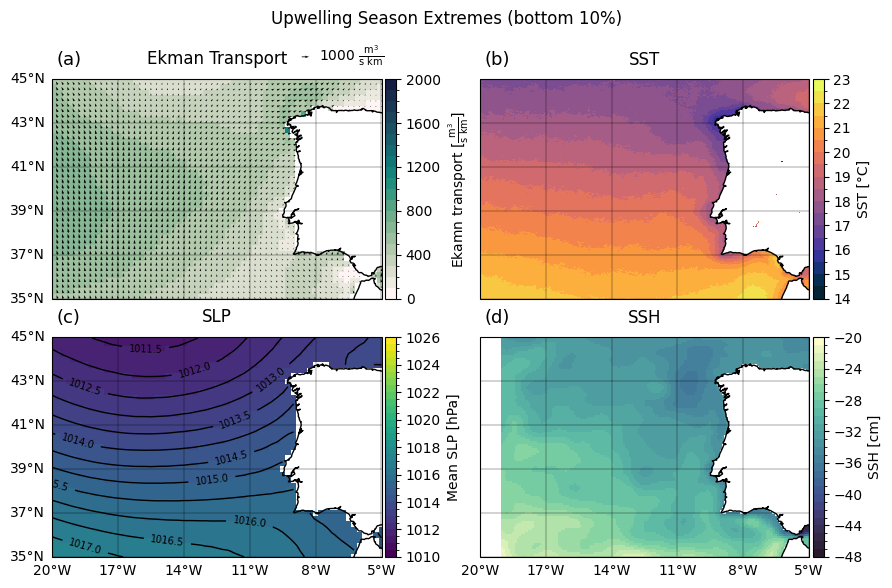

In [436]:
fig, ax = plt.subplots(2, 2, figsize = (9,6), subplot_kw={'projection': ccrs.PlateCarree()})
ax = ax.flatten()

# set up cartopy for all plots
for i in np.arange(4):
    ax[i].set_extent([-20.01, -4.99, 45.01, 34.99])
    ax[i].coastlines()
    gls = ax[i].gridlines(draw_labels=True, linewidth = 0.25, color = 'black')
    gls.top_labels = False 
    gls.right_labels = False
    gls.xlocator = mticker.FixedLocator(np.arange(-20, -4, 3))
    gls.ylocator = mticker.FixedLocator(np.arange(35, 46, 2))
    if i in (1, 3):
        gls.left_labels = False
    if i in (0, 1):
        gls.bottom_labels = False

#cp = Ek_comp_bottom.magnitude.plot(ax = ax[0], add_colorbar = False, cmap = cmo.tempo, vmin = 0, vmax = 2000, alpha = 0.8, levels = np.arange(0, 2100, 100))
mag_bottom = np.hypot(Ek_comp_bottom.ek_trans_u, Ek_comp_bottom.ek_trans_v)
cmap = cmo.tempo
norm = mcolors.BoundaryNorm(np.arange(0, 2100, 100), ncolors = cmap.N, clip = True)
cp = ax[0].imshow(mag_bottom, origin = 'lower', extent=[-20, -5, 35, 45], norm = norm, cmap = cmap)
im = ax[0].quiver(Ek_comp_bottom.lon, Ek_comp_bottom.lat, Ek_comp_bottom.ek_trans_u, Ek_comp_bottom.ek_trans_v, angles='xy', scale_units='xy', scale = 3*1000) #, clim = [0,2*1000]) 
plt.colorbar(cp, ax = ax[0], label = r'Ekamn transport [$\frac{\rm m^3}{\rm s \ km}$]', fraction = 0.0319, pad = 0.01, ticks = np.arange(0, 2400, 400));
ax[0].set_title('Ekman Transport')
ax[0].text(-19.8, 45.65, '(a)', fontsize = 13)
ax[0].quiverkey(im, 0.78, 1.1, 1*1000, r'1000 $\frac{\rm m^3}{\rm s \ km}$', labelpos='E')

cp = SST_comp_bottom.plot(ax = ax[1], add_colorbar = False, cmap = cmo.thermal, vmin = 14, vmax = 23, levels = np.arange(14, 23.5, 0.5))
plt.colorbar(cp, ax = ax[1], label = 'SST [°C]', fraction = 0.0319, pad = 0.01) 
ax[1].set_title('SST', pad = 10)
ax[1].text(-19.8, 45.65, '(b)', fontsize = 13)

cp = SLP_comp_bottom.plot(ax = ax[2], add_colorbar = False, cmap = 'viridis', vmin = 1010, vmax = 1026, levels = np.arange(1010, 1026.5, 0.5))
clp = SLP_comp_bottom.plot.contour(ax = ax[2], colors = 'black', linewidths = 1, levels = np.arange(1010, 1026.5, 0.5))
plt.colorbar(cp, ax = ax[2], label = 'Mean SLP [hPa]', fraction = 0.0319, pad = 0.01) 
plt.clabel(clp, fontsize = 7)
ax[2].set_title('SLP')
ax[2].text(-19.8, 45.65, '(c)', fontsize = 13)

cp = SSH_comp_bottom.plot(ax = ax[3], add_colorbar = False, cmap = cmo.deep_r, vmin = -48, vmax = -22, levels = np.arange(-48, -19, 1))
cbar = plt.colorbar(cp, ax = ax[3], label = 'SSH [cm]', fraction = 0.0319, pad = 0.01, ticks = np.arange(-48, -16, 4))
#cbar.ax.locator_params(nbins = 4)
ax[3].set_title('SSH', pad = 10)
ax[3].text(-19.8, 45.65, '(d)', fontsize = 13)

fig.suptitle('Upwelling Season Extremes (bottom 10%)')
fig.tight_layout(pad=1, w_pad=0, h_pad=-0.8)
fig.savefig('Upwelling_Season_Extremes_bottom.png', dpi = 300, bbox_inches = 'tight')

In [435]:
# min and max values overall 
print('Ek (combined) min:', Ek_comp_bottom.magnitude.min().values, 'max: ', Ek_comp_bottom.magnitude.max().values)
print('Ek (combined) min:', np.nanmin(mag_bottom.values), 'max: ', np.nanmax(mag_bottom.values))
print('SST min: ', SST_comp_bottom.min().values, 'max: ', SST_comp_bottom.max().values)
print('SLP min: ', SLP_comp_bottom.min().values, 'max: ', SLP_comp_bottom.max().values)
print('SSH min: ', SSH_comp_bottom.min().values, 'max: ', SSH_comp_bottom.max().values)

Ek (combined) min: 15.289371823932797 max:  1942.7327581007844
Ek (combined) min: 28.9950072111708 max:  1105.5687261576884
SST min:  14.799864864864862 max:  22.323648648648646
SLP min:  1011.3335 max:  1017.46356
SSH min:  -45.550895020694156 max:  -21.313393869474694
